In [1]:
import caiman as cm
import numpy as np
import matplotlib.pyplot as plt
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from pathlib import Path
import pickle
import glob
import gc

2023-02-27 16:46:04.765215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data_path = Path("/ceph/imaging1/arie")

sessions ={'429420_toms': ['20230202','20230203','20230210','20230211','20230313','20230314'],
           '429419_croc': ['20230202','20230203','20230210','20230211','20230313','20230314']}


In [ ]:
mean_imgs = {}
frame_avgs = {}

for animal in sessions.keys():
    mean_imgs[animal] = {}
    frame_avgs[animal] = {}
    
    for date in sessions[animal]:
        animal_n = animal.split('_')[0]
        session_path = data_path.joinpath(f'{animal}/{date}_{animal_n}')
        print(f'Computing {session_path}')

        try:
            tif_file = glob.glob(str(session_path)+'/*.tif')[0]
            log_file = glob.glob(str(session_path)+'/*.b64')[0]

        except IndexError:
            print('Files not found, skipping session')
            
            
        
            
        movie = cm.load(tif_file)
        mean_img = np.mean(movie,axis=0)
        fr_avg = np.mean(movie,axis=[1,2])
        
        mean_imgs[animal][data] = mean_img
        frame_avgs[animal][data] = fr_avg
        
        del(movie)
        gc.collect()
        
        

Computing /ceph/imaging1/arie/429420_toms/20230202_429420


In [ ]:
animal =
date = 

cropping = [100, -100, 100, -100]

plt.figure(figsize=(10,10))
plt.imshow(mean_imgs[animal][date],cmap=plt.cm.gnuplot2)

plt.axhline(y=cropping[0],c='r')
plt.axhline(y=cropping[1],c='r')
plt.axvline(y=cropping[2],c='r')
plt.axvline(y=cropping[3],c='r')





# Raw video metrics

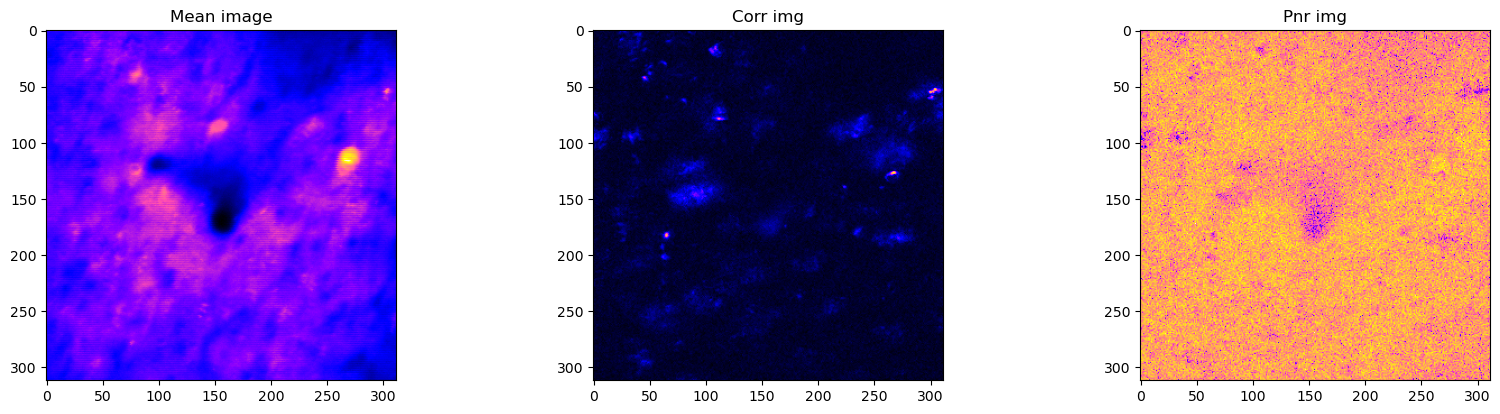

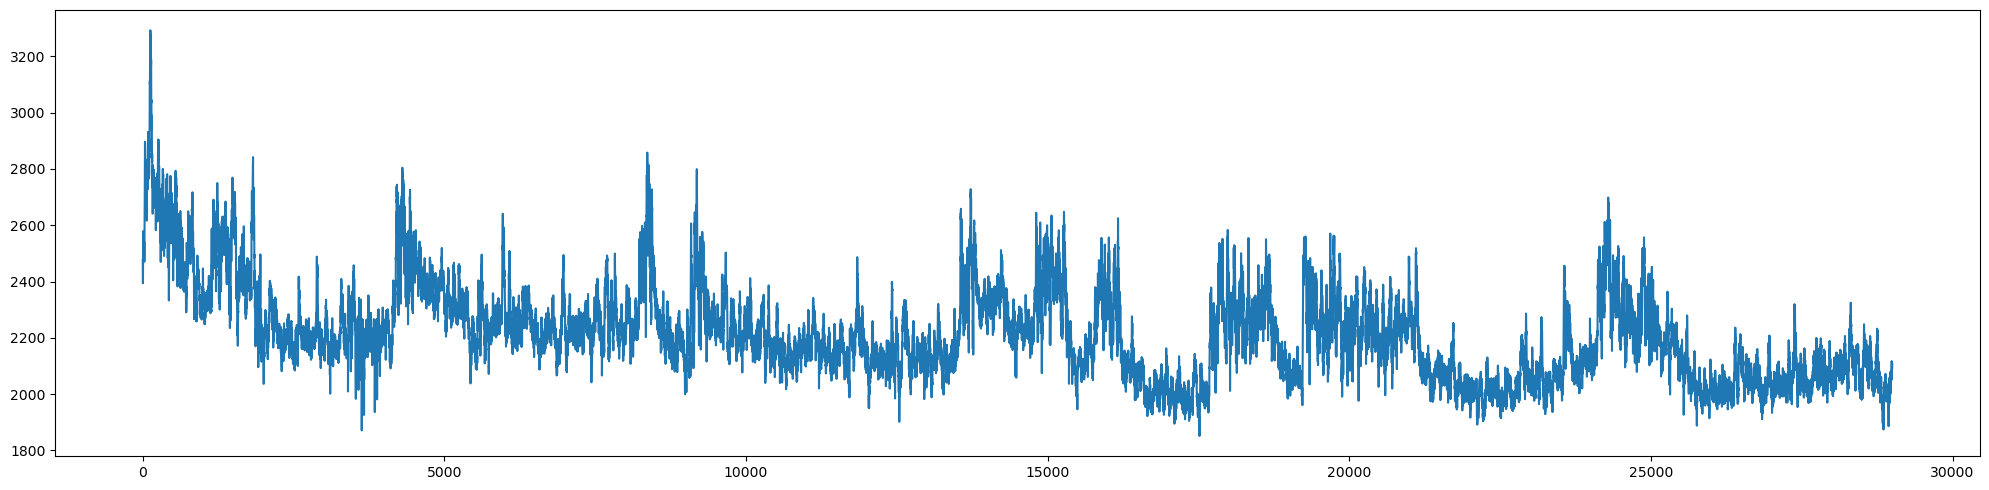

In [98]:
metrics_file = data_path.joinpath('raw_metrics.pickle')
with open(metrics_file,'rb') as file:
    metrics = pickle.load(file)


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.title('Mean image')
plt.imshow(metrics['mean_image'],cmap=plt.cm.gnuplot2)

plt.subplot(2,3,2)
plt.title('Corr img')
plt.imshow(metrics['corr_pnr_images'][0],cmap=plt.cm.gnuplot2)

plt.subplot(2,3,3)
plt.title('Pnr img')
plt.imshow(metrics['corr_pnr_images'][1],cmap=plt.cm.gnuplot2_r)

plt.figure(figsize=(20,5))
plt.plot(metrics['frame_average'])


plt.tight_layout()

In [99]:
mcor_file = data_path.joinpath('cropped_20230210_429420_00001_els__d1_312_d2_312_d3_1_order_F_frames_94726.mmap')
movie = cm.load(mcor_file)
corr_img,pnr_img = cm.summary_images.correlation_pnr(movie,swap_dim=False)

Decode mmap filename /scratch/dspalla/2p_data/429420_toms/20230210/cropped_20230210_429420_00001_els__d1_312_d2_312_d3_1_order_F_frames_94726.mmap


KeyboardInterrupt: 

In [ ]:
plt.imshow(corr_img,cmap=plt.cm.gnuplot2)

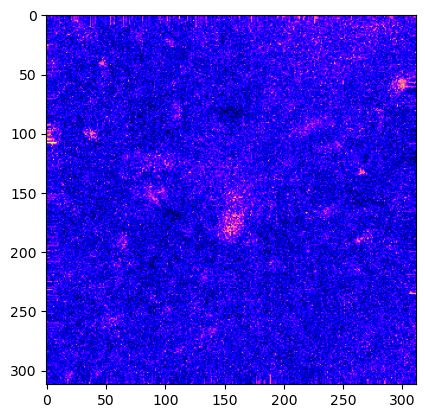

In [77]:
plt.imshow(pnr_img,cmap=plt.cm.gnuplot2)

KeyError: 'corr_pnr_images'

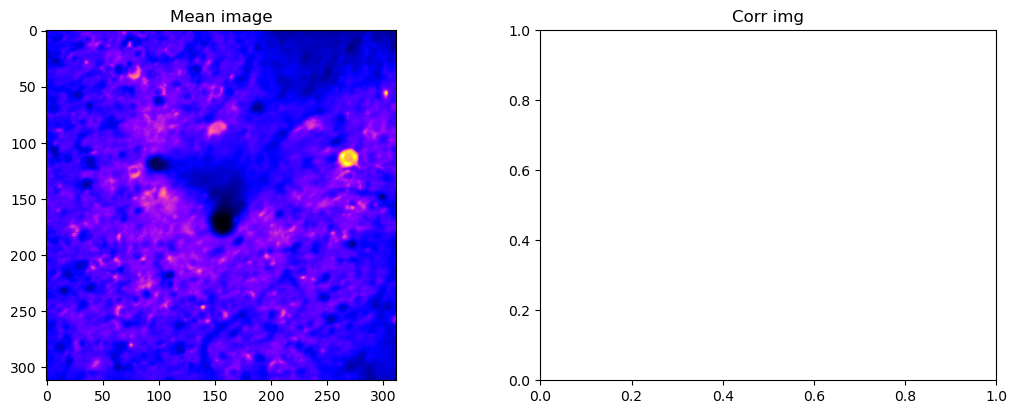

In [100]:
metrics_file = data_path.joinpath('mcorr_metrics.pickle')
with open(metrics_file,'rb') as file:
    metrics = pickle.load(file)


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.title('Mean image')
plt.imshow(metrics['mean_image'],cmap=plt.cm.gnuplot2)

plt.subplot(2,3,2)
plt.title('Corr img')
plt.imshow(metrics['corr_pnr_images'][0],cmap=plt.cm.gnuplot2)

plt.subplot(2,3,3)
plt.title('Pnr img')
plt.imshow(metrics['corr_pnr_images'][1],cmap=plt.cm.gnuplot2_r)

plt.figure(figsize=(20,5))
plt.plot(metrics['frame_average'])


plt.tight_layout()

# separated sources

In [101]:
cnmf_file = data_path.joinpath('cnmf.hdf5')
cnmf = load_CNMF(cnmf_file)
ests = cnmf.estimates

print(f'total # of components:{len(ests.idx_components)+len(ests.idx_components_bad)}')
print(f'GOOD components:{len(ests.idx_components)}')
print(f'BAD components:{len(ests.idx_components_bad)}')

total # of components:604
GOOD components:132
BAD components:472


In [35]:
a = ests.A[:,ests.idx_components].toarray().reshape(ests.dims[0],ests.dims[1],len(ests.idx_components))

<Figure size 2000x1000 with 0 Axes>

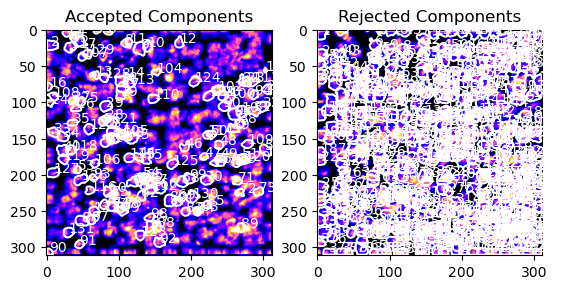

In [102]:
ests = cnmf.estimates
plt.figure(figsize=(20,10))
#ests.plot_contours(img=np.asarray(metrics['mean_image']),idx=ests.idx_components,cmap=plt.cm.gnuplot2)
ests.plot_contours(idx=ests.idx_components,cmap=plt.cm.gnuplot2)

In [103]:
from scipy.stats import zscore
plt.figure(figsize=(10,5))
zstep=0.1

for i in range(10):
    trace = C[ests.idx_components][i,:1000]
    trace = zscore(trace)
    plt.plot(trace+i*zstep)

NameError: name 'C' is not defined

<Figure size 1000x500 with 0 Axes>

In [7]:
neural_data = {}
neural_data['traces'] = ests.C[ests.idx_components]
neural_data['df_f'] = ests.F_dff[ests.idx_components]
neural_data['deconvolved'] = ests.S[ests.idx_components]
neural_data['positions'] = np.asarray([i['CoM'] for i in ests.coordinates])[ests.idx_components]
neural_data['footprints'] = [l['coordinates'] for i,l in enumerate(ests.coordinates) if i in ests.idx_components]

In [128]:
spikes = []
for trace in neural_data['deconvolved']:
    spikes.append(np.where(trace>0)[0])


133
958


In [8]:
?ests.

Type:           Estimates
String form:    <caiman.source_extraction.cnmf.estimates.Estimates object at 0x1555459e0c40>
File:           /scratch/dspalla/mambaforge/envs/mescore/lib/python3.10/site-packages/caiman/source_extraction/cnmf/estimates.py
Docstring:     
Class for storing and reusing the analysis results and performing basic
processing and plotting operations.
Init docstring:
Class for storing the variables related to the estimates of spatial footprints, temporal traces,
deconvolved neural activity, and background. Quality metrics are also stored. The class has methods
for evaluating the quality of each component, DF/F normalization and some basic plotting.

Args:
    A:  scipy.sparse.csc_matrix (dimensions: # of pixels x # components)
        set of spatial footprints. Each footprint is represented in a column of A, flattened with order = 'F'

    C:  np.ndarray (dimensions: # of components x # of timesteps)
        set of temporal traces (each row of C corresponds to a trace

In [125]:
neural_data['deconvolved'].shape

(133, 29000)

<Figure size 1000x500 with 0 Axes>

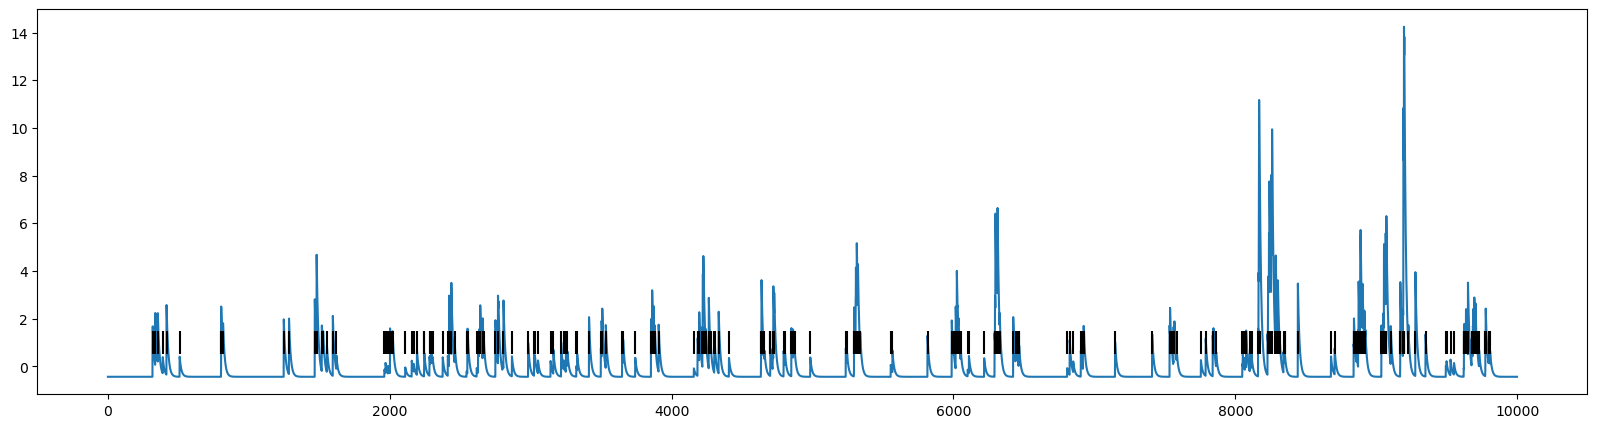

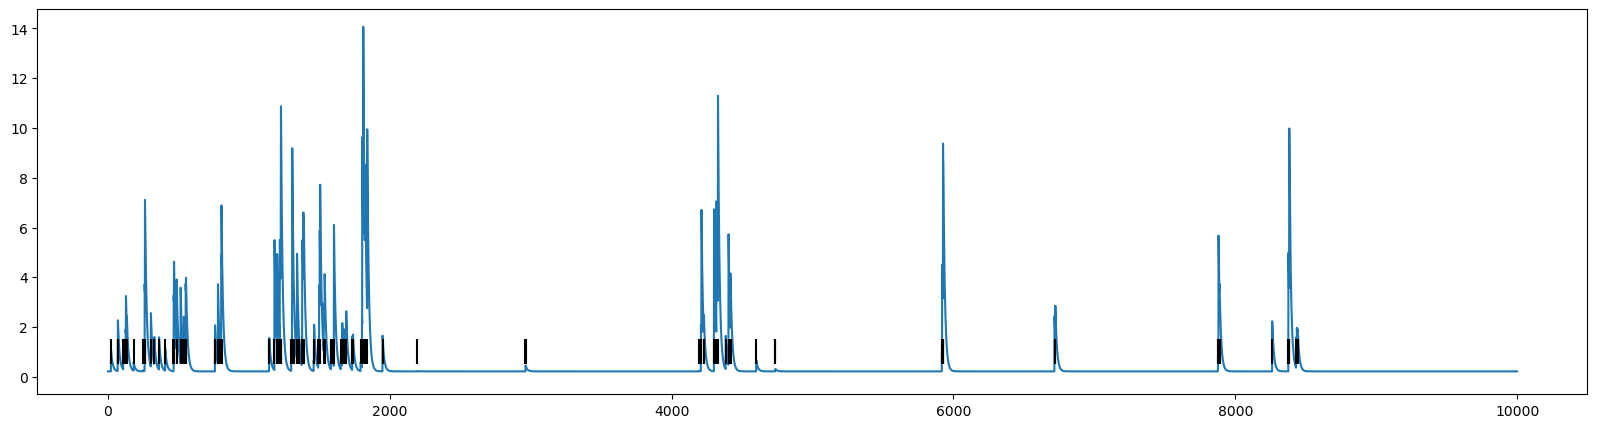

In [115]:
from scipy.stats import zscore
plt.figure(figsize=(10,5))
zstep=0.5

for i in range(2):
    plt.figure(figsize=(20,5))
    trace = neural_data['traces'][i,:10000]
    trace = zscore(trace)
    plt.plot(trace+i*zstep)
    
    spikes = np.where(neural_data['deconvolved'][i,:10000]>0)[0]
    
    plt.eventplot(spikes,color='k')

In [51]:
save_path = data_path.joinpath('neural_data.npy')
filehandler = open(save_path, 'wb') 
pickle.dump(neural_data, filehandler)
filehandler.close()

In [31]:
c = {'x':1,'y':2}
a = {'a':1,'b':c}

In [37]:
with open('prova.yml','w') as file:
    yaml.dump(a,file)

In [36]:
coms = np.asarray([i['CoM'] for i in ests.coordinates])[ests.idx_components]

In [45]:
len(ests.coordinates)

627

In [41]:
import pickle

In [44]:
data_path = Path("/ceph/imaging1/davide/2p_data/429420_toms/20230210")
filehandler = open(data_path.joinpath('neural_data.pickle'), 'rb')
neural_data = pickle.load(filehandler)
filehandler.close()

In [88]:
neural_data.keys()

dict_keys(['traces', 'footprints', 'df_f', 'deconvolved', 'positions', 'contour'])

In [90]:
traces = neural_data['traces']
spikes = neural_data['deconvolved']
positions = neural_data['positions']

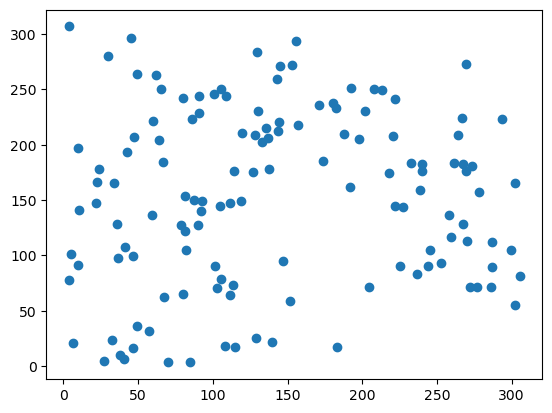

In [95]:
plt.scatter(positions[:,1],positions[:,0])

(-1.0, 5.0)

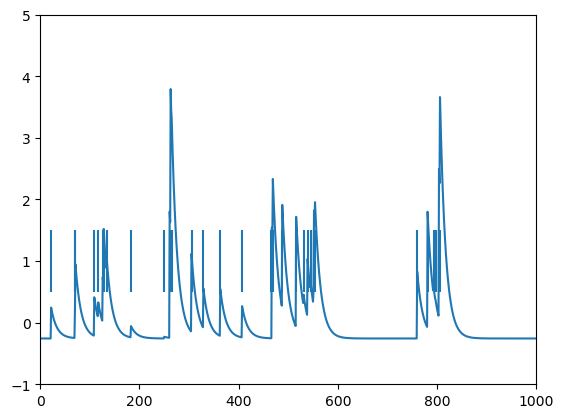

In [86]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

neuron = 1
plt.plot(zscore(traces[neuron]))
plt.eventplot(spikes[neuron])
plt.xlim([0,1000])
plt.ylim([-1,5])

In [69]:
import numpy as np

In [73]:
np.corrcoef(traces[0],traces[1])[0,1]

0.022051987341533755